# Routing, speed imputation, and travel times

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)

In [1]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

/var/folders/3h/dgk1gddd4vd7jthqz32mnkhh0000gn/T/ipykernel_16814/2956791432.py:3: FutureWarning: The `utils.config` function is deprecated and will be removed in the v2.0.0 release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


In [28]:
place = 'Fullerton, CA, USA'
G = ox.graph_from_place(place, network_type='drive')

## 1. Fast nearest node/edge search with OSMnx

In [59]:
# convert graph to geodataframes
gdf_edges = ox.graph_to_gdfs(G, nodes=False)

# list of lats and lngs
lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])
# the lat, lng at the spatial center of the graph
lng, lat = gdf_edges.unary_union.centroid.coords[0]
center_point = [lat, lng]


/var/folders/3h/dgk1gddd4vd7jthqz32mnkhh0000gn/T/ipykernel_16814/3473239674.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lngs = gdf_edges.head().centroid.map(lambda x: x.coords[0][0])
/var/folders/3h/dgk1gddd4vd7jthqz32mnkhh0000gn/T/ipykernel_16814/3473239674.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  lats = gdf_edges.head().centroid.map(lambda x: x.coords[0][1])


In [30]:
# find the nearest node to some point
center_node = ox.nearest_nodes(G, center_point[0],center_point[1])

In [53]:
# find the nearest nodes to a set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_nodes = ox.nearest_nodes(G, lngs, lats)
print(nearest_nodes)

u         v          key
20972501  257003017  0     -117.969403
67543004  122680542  0     -117.939330
          964923618  0     -117.938669
          122814522  0     -117.938153
          67543020   0     -117.940583
dtype: float64
[1832755534, 67543004, 67543004, 964923618, 67543004]


In [32]:
# find the nearest edge to some point
nearest_edge = ox.nearest_edges(G, center_point[0], center_point[1])

In [33]:
# find the nearest edges to some set of points
# optionally specify `method` use use a kdtree or balltree index
nearest_edges = ox.nearest_edges(G, lngs, lats)

## 2. Basic routing by distance

Pick two nodes. Then find the shortest path between origin and destination, using weight='length' to find the shortest path by minimizing distance traveled (otherwise it treats each edge as weight=1).

20972501 11566213712


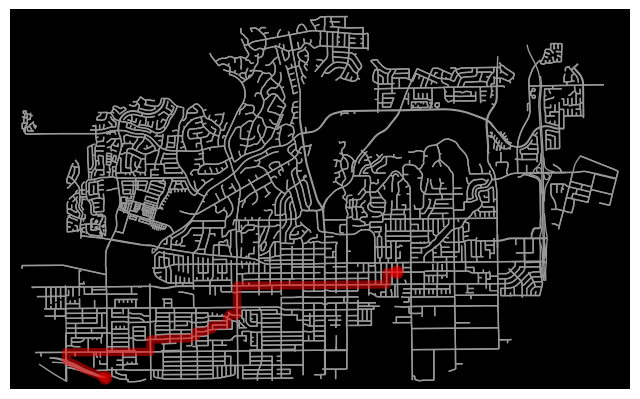

In [36]:
# find the shortest path (by distance) between these nodes then plot it
orig = list(G)[0]
dest = list(G)[-1]
print(orig, dest)
route = nx.shortest_path(G, orig, dest, weight='length')
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')

The routing correctly handles one-way streets:

[20972501, 28311200, 67543004, 67543020, 67543057, 67543067, 75224351, 122560104, 122562951, 122562954, 122562971, 122565442, 122569695, 122570065, 122570068, 122579384, 122579412, 122581824, 122584906, 122584909, 122584918, 122584921, 122586157, 122586179, 122586833, 122586836, 122589799, 122589814, 122599336, 122599339, 122599341, 122599348, 122599352, 122602016, 122602019, 122603522, 122603524, 122603533, 122603535, 122603541, 122603544, 122604463, 122604473, 122606565, 122606570, 122606714, 122609242, 122609248, 122614996, 122615004, 122616459, 122616972, 122617702, 122618984, 122619753, 122620602, 122620604, 122620846, 122620984, 122620988, 122621455, 122621458, 122621467, 122621468, 122621748, 122621750, 122621752, 122622777, 122622781, 122624368, 122624380, 122624382, 122624607, 122624638, 122624640, 122624941, 122624946, 122624952, 122627090, 122627092, 122627096, 122627097, 122627099, 122627102, 122627105, 122627426, 122627428, 122627430, 122628013, 122628016, 122628018, 12262

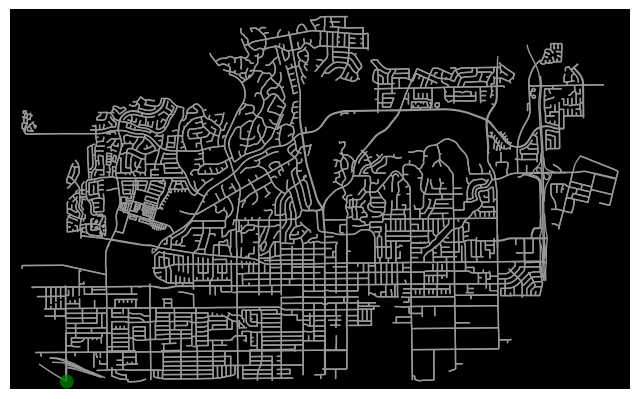

In [58]:
# G2 = ox.graph_from_address('Fullerton, California', dist=800, network_type='drive')
origin = (33.877477, -117.887313)
destination = (33.869568, -117.922977)
print(list(G))
origin_node = ox.nearest_nodes(G, origin[0],origin[1], return_dist=False)
destination_node = ox.nearest_nodes(G, destination[0], destination[1], return_dist=False)
print(origin_node, destination_node)
route = nx.shortest_path(G, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6,route_color='g', node_size=0, bgcolor='k')

Also, when there are parallel edges between nodes in the route, OSMnx picks the shortest edge to plot:

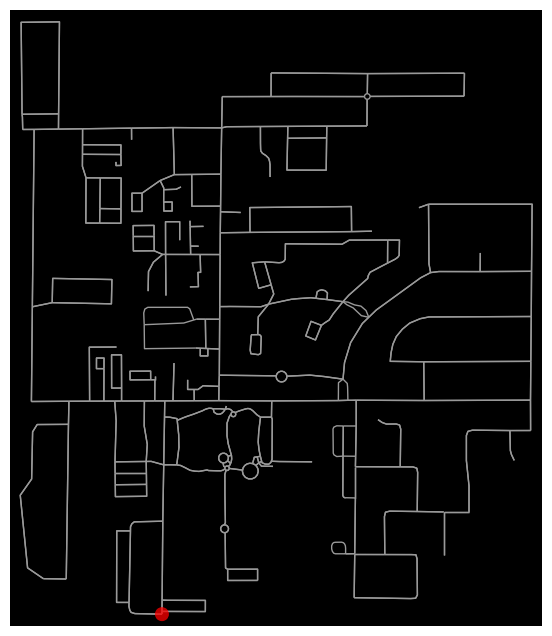

In [19]:
location_point = (33.299896, -111.831638)
G2 = ox.graph_from_point(location_point, dist=500 )
origin = (33.301821, -111.829871)
destination = (33.301402, -111.833108)
origin_node = ox.nearest_nodes(G2, origin[0],origin[1])
destination_node = ox.nearest_nodes(G2, destination[0],destination[1])
route = nx.shortest_path(G2, origin_node, destination_node)
fig, ax = ox.plot_graph_route(G2, route, route_linewidth=6, node_size=0, bgcolor='k')

## 3. Imputing travel speeds and times

The `add_edge_speeds` function add edge speeds (km per hour) to graph as new `speed_kph` edge attributes. Imputes free-flow travel speeds for all edges based on mean `maxspeed` value of edges, per highway type. This mean-imputation can obviously be imprecise, and the caller can override it by passing in `hwy_speeds` and/or `fallback` arguments that correspond to local speed limit standards. See docstring for details.

In [42]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [43]:
# see mean speed/time values by road type
edges = ox.graph_to_gdfs(G, nodes=False)
edges['highway'] = edges['highway'].astype(str)
edges.groupby('highway')[['length', 'speed_kph', 'travel_time']].mean().round(1)

,length,speed_kph,travel_time
highway,,,
"['residential', 'tertiary']",328.5,37.0,31.7
"['residential', 'unclassified']",524.8,29.8,63.4
"['unclassified', 'tertiary']",518.1,38.7,48.2
motorway,573.5,103.1,20.7
motorway_link,242.4,104.6,8.3
primary,207.3,69.4,10.7
primary_link,43.9,68.4,2.4
residential,125.1,29.8,15.1
secondary,162.4,64.7,9.0


In [44]:
# same thing again, but this time pass in a few default speed values (km/hour)
# to fill in edges with missing `maxspeed` from OSM
hwy_speeds = {'residential': 35,
              'secondary': 50,
              'tertiary': 60}
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

In [47]:
# calculate two routes by minimizing travel distance vs travel time
orig = list(G)[1]
dest = list(G)[-5]
route1 = nx.shortest_path(G, orig, dest, weight='length')
route2 = nx.shortest_path(G, orig, dest, weight='travel_time')

NetworkXNoPath: No path between 28311200 and 11501888346.

In [ ]:
# compare the two routes
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time')))
route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time')))
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'seconds.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'seconds.')

In [ ]:
# pick route colors
c1 = 'r' #length
c2 = 'b' #travel_time
rc1 = [c1] * (len(route1) - 1)
rc2 = [c2] * (len(route2) - 1)
rc = rc1 + rc2
nc = [c1, c1, c2, c2]

# plot the routes
fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, route_linewidth=6,
                               orig_dest_node_color=nc, node_size=0, bgcolor='k')

The blue route minimizes travel time, and is thus longer but faster than the red route.

For more examples of travel time, see the [isochrones example](13-isolines-isochrones.ipynb).

For more examples of routing, including using elevation as an impedance, see the [elevations example](12-node-elevations-edge-grades.ipynb).